# Homework 3 By Weile Chen
## Problem 1

In [211]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,AveragePooling2D
from keras.models import Model
from keras import backend as K
from keras.preprocessing import image
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.utils import np_utils
import matplotlib.pyplot as plt
import tensorflow as tf

In [212]:
# load data 
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [213]:
# normalize data
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

# flatten the 28*28 images into vectors of size 784
X_train = X_train.reshape((X_train.shape[0],28,28,1))
X_test = X_test.reshape((X_test.shape[0],28,28,1))

print(X_train.shape)
print(X_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


Build a CNN with convolution layers for the encoder part and UpSampling2D layers for the decoder part.

In [214]:
# place holder
input_img = Input(shape=(28,28,1))

# build our encoder
x = Conv2D(16,(3,3), activation = 'relu',padding='same')(input_img)
x = AveragePooling2D((2,2),padding='same')(x)
x = Conv2D(8,(3,3), activation = 'relu',padding='same')(x)
x = MaxPooling2D((2,2),padding='same')(x)
x = Conv2D(8,(3,3), activation = 'relu',padding='same')(x)
x = MaxPooling2D((2,2),padding='same')(x)
x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(4, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [215]:
print (autoencoder.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
average_pooling2d_1 (Average (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)           0   

In [216]:
# for TensorFlow backend training
# tensorboard --logdir=/tmp/autoencoder

In [235]:
from keras.callbacks import TensorBoard

autoencoder.fit(X_train, X_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 54s 905us/step - loss: 0.4263 - val_loss: 0.3964
Epoch 2/10
60000/60000 [==============================] - 53s 876us/step - loss: 0.3602 - val_loss: 0.3490
Epoch 3/10
60000/60000 [==============================] - 54s 897us/step - loss: 0.3445 - val_loss: 0.3377
Epoch 4/10
60000/60000 [==============================] - 54s 895us/step - loss: 0.3348 - val_loss: 0.3283
Epoch 5/10
60000/60000 [==============================] - 54s 894us/step - loss: 0.3304 - val_loss: 0.3355
Epoch 6/10
60000/60000 [==============================] - 56s 937us/step - loss: 0.3272 - val_loss: 0.3273
Epoch 7/10
60000/60000 [==============================] - 52s 875us/step - loss: 0.3252 - val_loss: 0.3249
Epoch 8/10
60000/60000 [==============================] - 60s 999us/step - loss: 0.3236 - val_loss: 0.3222
Epoch 9/10
60000/60000 [==============================] - 56s 939us/step - loss: 0.3220 - val_

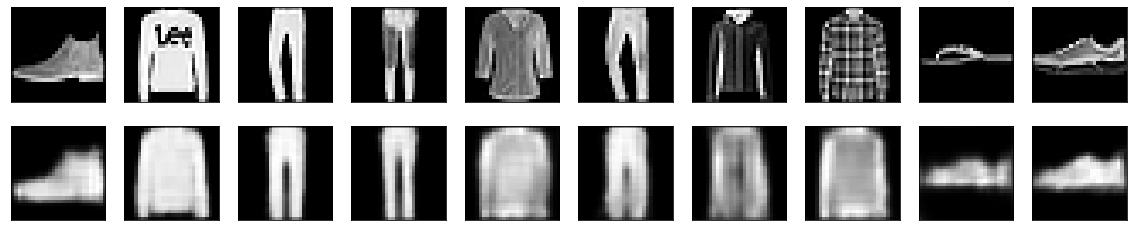

In [236]:
decoded_imgs = autoencoder.predict(X_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Problem 2
### 2.1 Deep CNN
Brief description of the deep CNN:
We have 3 convolutional layers, 1 max-pooling layer, 2 drop-out layers, 2 dense layers. Kernel size here is 3 by 3, stride is 1 by 1, and no padding.

In [217]:
# we convert our y into one-hot vector
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)
print(Y_test[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [218]:
# construct our deep cnn model
cnn_model = Sequential()
cnn_model.add(Conv2D(filters = 32, kernel_size = (3,3),
                    activation = 'relu', strides=(1,1),
                    padding='valid'))
cnn_model.add(Conv2D(filters = 32, kernel_size = (3,3),
                    activation = 'relu', strides=(1,1),
                    padding='valid'))
cnn_model.add(Conv2D(filters = 32, kernel_size = (3,3),
                    activation = 'relu', strides=(1,1),
                    padding='valid'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
#cnn_model.add(Dropout(0.25))


cnn_model.add(Dropout(0.25))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(10, activation='softmax'))

In [221]:
cnn_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [223]:
cnn_model.summary()

In [226]:
model_training = cnn_model.fit(X_train, Y_train,
          epochs=15,
          batch_size=128,
         verbose = 0)

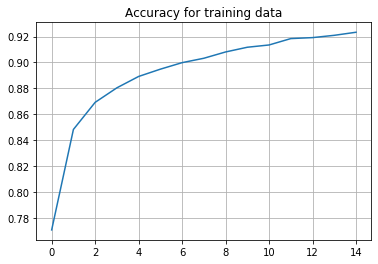

In [602]:
plt.plot(model_training.history["accuracy"])
plt.title("Accuracy for training data")
plt.grid()

In [14]:
_,train_acc = cnn_model.evaluate(X_train,Y_train,verbose=0)
_,test_acc = cnn_model.evaluate(X_test,Y_test,verbose=0)

In [15]:
from sklearn.metrics import f1_score
yhat_train = cnn_model.predict_classes(X_train)
yhat_test = cnn_model.predict_classes(X_test)

f1_score_train = f1_score(y_train,yhat_train, average='weighted')
f1_score_test = f1_score(y_test,yhat_test, average='weighted')

In [59]:
print("Deep CNN Performance")
print("#############################################################")
print("For train data set accuracy is:%f, f1 score is:%f"
      %(train_acc,f1_score_train))
print("For test data set accuracy is:%f, f1 score is:%f"
      %(test_acc,f1_score_test))
print("#############################################################")

Deep CNN Performance
#############################################################
For train data set accuracy is:0.958017, f1 score is:0.957937
For test data set accuracy is:0.922300, f1 score is:0.922144
#############################################################


From above results, we find the performance of our deep CNN is good enough and there is not evidence for overfitting.

### 2.2 Transfer Learning

In [51]:
# construction of our model
from keras.applications import VGG16, ResNet50
conv_base = VGG16(weights="imagenet",include_top=False,input_shape=(32,32,3))
conv_base.trainable = False
transfer_learning_model = Sequential()
transfer_learning_model.add(conv_base)
transfer_learning_model.add(Flatten())
transfer_learning_model.add(Dense(10, activation="softmax"))

In [60]:
transfer_learning_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                5130      
Total params: 14,719,818
Trainable params: 5,130
Non-trainable params: 14,714,688
_________________________________________________________________


In [54]:
# data preprocessing
import tensorflow as tf
## convert gray scale image to rgv
def to_rgb(img):
    img= K.expand_dims(img, axis=-1)
    tiling = [1] * 4    
    tiling[-1] *= 3
    img= K.tile(img, tiling)
    return img

with tf.compat.v1.Session() as ses:
    X_train_rgb = to_rgb(X_train)
    X_test_rgb = to_rgb(X_test)
    X_train_rgb = tf.image.resize(X_train_rgb, [32, 32])
    X_test_rgb = tf.image.resize(X_test_rgb, [32, 32])
    X_train_rgb = ses.run(X_train_rgb)
    X_test_rgb= ses.run(X_test_rgb)

In [55]:
transfer_learning_model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=["acc"])

In [56]:
transfer_learning_model.fit(X_train_rgb, Y_train, epochs=10, validation_data=(X_test_rgb, Y_test), batch_size=128)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 237s 4ms/step - loss: 1.9941 - acc: 0.7179 - val_loss: 1.0377 - val_acc: 0.7763
Epoch 2/10
60000/60000 [==============================] - 245s 4ms/step - loss: 0.8209 - acc: 0.8001 - val_loss: 0.7670 - val_acc: 0.8012
Epoch 3/10
60000/60000 [==============================] - 241s 4ms/step - loss: 0.6703 - acc: 0.8133 - val_loss: 0.7290 - val_acc: 0.8013
Epoch 4/10
60000/60000 [==============================] - 241s 4ms/step - loss: 0.6147 - acc: 0.8197 - val_loss: 0.7243 - val_acc: 0.7988
Epoch 5/10
60000/60000 [==============================] - 242s 4ms/step - loss: 0.5849 - acc: 0.8257 - val_loss: 0.6736 - val_acc: 0.8083
Epoch 6/10
60000/60000 [==============================] - 242s 4ms/step - loss: 0.5720 - acc: 0.8271 - val_loss: 0.6162 - val_acc: 0.8198
Epoch 7/10
60000/60000 [==============================] - 244s 4ms/step - loss: 0.5726 - acc: 0.8271 - val_loss: 0.6345 - 

In [64]:
# prediction
yhat_train = transfer_learning_model.predict_classes(X_train_rgb)
yhat_test = transfer_learning_model.predict_classes(X_test_rgb)


In [66]:
from sklearn.metrics import f1_score,accuracy_score
train_acc = accuracy_score(y_train,yhat_train)
test_acc = accuracy_score(y_test,yhat_test)
f1_score_train = f1_score(y_train,yhat_train, average='weighted')
f1_score_test = f1_score(y_test,yhat_test, average='weighted')

In [68]:
print("Transfer Learning from VGG16 Performance")
print("#############################################################")
print("For train data set accuracy is:%f, f1 score is:%f"
      %(train_a,f1_score_train))
print("For test data set accuracy is:%f, f1 score is:%f"
      %(test_acc,f1_score_test))
print("#############################################################")

Transfer Learning from VGG16 Performance
#############################################################
For train data set accuracy is:0.826083, f1 score is:0.819809
For test data set accuracy is:0.807400, f1 score is:0.801023
#############################################################


## Problem 3
### 3.1 RNN

In [581]:
# --- Libraries ---
# - Base libs - 
import os, sys
import numpy as np
import pandas as pd
import collections
import string, re, nltk

# -sklearn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

# -nltk-
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# -Tensorflow-
import tensorflow as tf
from tensorflow.python.client import device_lib
# -Keras libs-
from keras.models import Sequential
from keras.layers import Dense, Embedding, SimpleRNN, LSTM, GRU, Input, GlobalMaxPooling1D
from keras.utils import plot_model # pydot, graphviz are dependencies
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.initializers import Constant


# -Plot libs-
import matplotlib.pyplot as plt
from IPython.display import SVG, display
#%matplotlib inline

In [346]:
# load data
tweets = []
categories = []

with open('tweets_with_labels.csv',"r") as f:
    col_names = f.readline()
    #col_names = col_names.split()
    line = f.readline()
    while line:
        line = line.split()
        line = line[1:len(line)]
        tweets.append(' '.join(line[1:len(line)-15]))
        category_temp = line[-15:]
        categories.append([float(i) for i in category_temp])
        line = f.readline()

In [347]:
df = pd.DataFrame(categories)
df.columns = ['k1','k2','k3','k4','k5','k6','k7','k8','k9','k10','k11','k12','k13','k14','k15']
df['tweets'] = tweets
df.head(5)

,k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15,tweets
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,1.0,0.0,0.0,0.000,0.0,0.0,for a Rainy Afternoon: {link}
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,1.0,0.0,0.0,0.000,0.0,0.0,@mention: I love rainy days.
2,0.0,0.0,0.0,0.0,0.0,0.0,1.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,Morning Chicago! Time to kick the Windy City i...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.604,0.0,0.196,0.0,0.0,0.0,0.201,0.0,0.0,lol! :) RT @mention: #alliwantis this type of ...
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,1.000,0.0,0.0,good morning sunshine


In [348]:
# clean data
def clean_data(tweet):
    # remove all links
    tweet = re.sub(r'https?://\S*', '',tweet)
    tweet = tweet.replace('[^\w\s]','')
    
    # remove special signals, tags
    tweet = re.sub(r'[#\-\.\n\;]','',tweet)
    tweet = re.sub(r'@[a-zA-Z0-9_]*','',tweet)
    tweet = re.sub(r'&\w+','',tweet)
    
    # define a stop-words list
    stop_words = set(list(string.punctuation)+['rt', 'via',"''","'s","n't","'m",'``','day','days']+stopwords.words('english'))
    
    
    # tokenize a tweet
    word_tokens = word_tokenize(tweet)
    valid_tokens = []
    for w in word_tokens:
        w = w.lower()
        if w not in stop_words:
            valid_tokens.append(w)
    return ' '.join(valid_tokens)

In [349]:
df['cleaned twt'] = df['tweets'].apply(clean_data)
df.head(5)

,k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15,tweets,cleaned twt
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,1.0,0.0,0.0,0.000,0.0,0.0,for a Rainy Afternoon: {link},rainy afternoon link
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,1.0,0.0,0.0,0.000,0.0,0.0,@mention: I love rainy days.,love rainy
2,0.0,0.0,0.0,0.0,0.0,0.0,1.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,Morning Chicago! Time to kick the Windy City i...,morning chicago time kick windy city nuts head...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.604,0.0,0.196,0.0,0.0,0.0,0.201,0.0,0.0,lol! :) RT @mention: #alliwantis this type of ...,lol alliwantis type weather time live beautifu...
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,1.000,0.0,0.0,good morning sunshine,good morning sunshine


In [350]:
length = df['cleaned twt'].apply(len)
max_len = max(length)
MAX_NUM_WORDS = len(set(df['cleaned twt'].apply(' '.join)))
print("MAX_NUM_WORDS:%i,max_len:%i"%(MAX_NUM_WORDS,max_len))

MAX_NUM_WORDS:73342,max_len:128


In [351]:
# --- Tokenizing texts ----
MAX_NUM_WORDS = 5000 
MAX_SEQUENCE_LENGTH = 100 

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(df['cleaned twt'])
sequences = tokenizer.texts_to_sequences(df['cleaned twt'])
X = sequence.pad_sequences(sequences,maxlen=max_len+1)
Y = df[df.columns[~df.columns.isin(['cleaned twt','tweets'])]]

In [352]:
# split data into train and test sets
X_train,X_test,Y_train_twt,Y_test_twt = train_test_split(X,Y,test_size=0.2,random_state=123)


X_train_twt = X_train_twt.reshape(X_train.shape+(1,))
X_test_twt = X_test_twt.reshape(X_test.shape+(1,))

In [198]:
# construction of GRU model
gru = Sequential()
# gru.add(Embedding(max_len+1,max_len+1))
gru.add(GRU(max_len,input_shape = (max_len+1,1), return_sequences = True))
gru.add(GRU(15, return_sequences = False))
gru.add(Dense(15,activation='softmax'))
gru.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["acc"])

In [199]:
gru.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_12 (GRU)                 (None, 129, 128)          49920     
_________________________________________________________________
gru_13 (GRU)                 (None, 15)                6480      
_________________________________________________________________
dense_6 (Dense)              (None, 15)                240       
Total params: 56,640
Trainable params: 56,640
Non-trainable params: 0
_________________________________________________________________


In [200]:
gru_history = gru.fit(X_train_twt,Y_train_twt,epochs = 10,batch_size=128,validation_split = 0.2,verbose=True)

Train on 49884 samples, validate on 12472 samples
Epoch 1/10
49884/49884 [==============================] - 129s 3ms/step - loss: 2.4534 - acc: 0.3830 - val_loss: 2.2722 - val_acc: 0.4649
Epoch 2/10
49884/49884 [==============================] - 130s 3ms/step - loss: 2.2168 - acc: 0.5053 - val_loss: 2.1719 - val_acc: 0.5300
Epoch 3/10
49884/49884 [==============================] - 133s 3ms/step - loss: 2.1367 - acc: 0.5503 - val_loss: 2.1101 - val_acc: 0.5741
Epoch 4/10
49884/49884 [==============================] - 129s 3ms/step - loss: 2.0950 - acc: 0.5819 - val_loss: 2.0924 - val_acc: 0.5832
Epoch 5/10
49884/49884 [==============================] - 129s 3ms/step - loss: 2.0713 - acc: 0.5894 - val_loss: 2.0648 - val_acc: 0.5940
Epoch 6/10
49884/49884 [==============================] - 128s 3ms/step - loss: 2.0594 - acc: 0.5877 - val_loss: 2.0531 - val_acc: 0.5920
Epoch 7/10
49884/49884 [==============================] - 128s 3ms/step - loss: 2.0496 - acc: 0.5931 - val_loss: 2.0442 - 

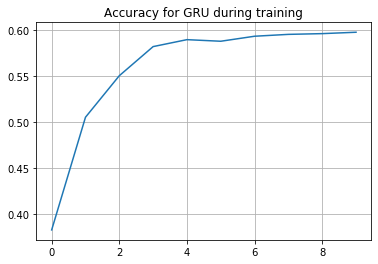

In [225]:
plt.plot(gru_history.history["acc"])
plt.title("Accuracy for GRU during training")
plt.grid()

In [205]:
_,gru_train_acc = gru.evaluate(X_train_twt,Y_train_twt,verbose=0)
_,gru_test_acc = gru.evaluate(X_test_twt,Y_test_twt,verbose=0)

In [202]:
yhat_train_gru = gru.predict_classes(X_train_twt)
yhat_test_gru = gru.predict_classes(X_test_twt)

In [209]:
print("GRU model for text classification")
print("#############################################################")
print("The accuracy for the train data set is:%f \nThe accuracy for the test data set is:%f"
      %(gru_train_acc,gru_test_acc))
print("#############################################################")

GRU model for text classification
#############################################################
The accuracy for the train data set is:0.598563 
The accuracy for the test data set is:0.599166
#############################################################


Since we use softmax for our final output, it would not really meet our final goal for this task. Therefore, the accuracy is not good. We could use a sigmoid for each category. Or, we could use a seq2seq model for this task. Furthermore, since each tweet is associated with one or more topics, a topic model like LDA would be a good choice. Alternatively, we could add a world-embedding layer to our model. But, it would require more computing power.

### 3.2 CNN
The idea here is to add a pre-trained world-embedding model to our simple cnn model.

In [533]:
BASE_DIR = ''
GLOVE_DIR = os.path.join(BASE_DIR, 'glove.6B')
MAX_SEQUENCE_LENGTH = max_len+1
EMBEDDING_DIM = 300

# first, build index mapping words in the embeddings set to their embedding vector
embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.300d.txt')) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [534]:
# prepare embedding matrix
word_index = tokenizer.word_index
num_words = min(MAX_NUM_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [535]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [549]:
cnn_twt = Sequential()
cnn_twt.add(embedding_layer)
# cnn_twt.add(Conv1D(64,5))
# cnn_twt.add(MaxPooling1D(5))
cnn_twt.add(Conv1D(8,2))
cnn_twt.add(MaxPooling1D(2))
cnn_twt.add(Flatten())
# cnn_twt.add(Dense(128, activation="relu"))
#cnn_twt.add(Dense(64, activation="relu"))
cnn_twt.add(Dense(64, activation="softmax"))
cnn_twt.add(Dense(32, activation="softmax"))
cnn_twt.add(Dense(15, activation="softmax"))

cnn_twt.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["acc"])
cnn_twt.summary()

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 129, 300)          1500000   
_________________________________________________________________
conv1d_141 (Conv1D)          (None, 128, 8)            4808      
_________________________________________________________________
max_pooling1d_87 (MaxPooling (None, 64, 8)             0         
_________________________________________________________________
flatten_48 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_152 (Dense)            (None, 64)                32832     
_________________________________________________________________
dense_153 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_154 (Dense)            (None, 15)              

In [550]:
cnn_history1 = cnn_twt.fit(X_train,Y_train_twt,batch_size =128,epochs=10,validation_data=(X_test,Y_test_twt))

Train on 62356 samples, validate on 15590 samples
Epoch 1/10
62356/62356 [==============================] - 18s 296us/step - loss: 2.8933 - acc: 0.2801 - val_loss: 2.6983 - val_acc: 0.2919
Epoch 2/10
62356/62356 [==============================] - 19s 305us/step - loss: 2.5770 - acc: 0.3261 - val_loss: 2.4370 - val_acc: 0.5012
Epoch 3/10
62356/62356 [==============================] - 19s 301us/step - loss: 2.3180 - acc: 0.5036 - val_loss: 2.1992 - val_acc: 0.5048
Epoch 4/10
62356/62356 [==============================] - 19s 306us/step - loss: 2.1227 - acc: 0.5065 - val_loss: 2.0583 - val_acc: 0.5072
Epoch 5/10
62356/62356 [==============================] - 19s 305us/step - loss: 2.0207 - acc: 0.5241 - val_loss: 1.9918 - val_acc: 0.5250
Epoch 6/10
62356/62356 [==============================] - 19s 301us/step - loss: 1.9773 - acc: 0.5291 - val_loss: 1.9710 - val_acc: 0.5254
Epoch 7/10
62356/62356 [==============================] - 19s 305us/step - loss: 1.9597 - acc: 0.5302 - val_loss: 1.

In [552]:
_,cnn_train_acc = cnn_twt.evaluate(X_train,Y_train_twt,verbose=0)
_,cnn_test_acc = cnn_twt.evaluate(X_test,Y_test_twt,verbose=0)

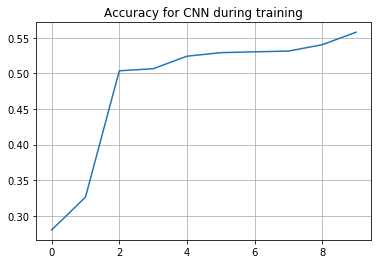

In [554]:
plt.plot(cnn_history1.history["acc"])
plt.title("Accuracy for CNN during training")
plt.grid()

In [553]:
print("CNN model with pre-trained embedding layer for text classification")
print("#############################################################")
print("The accuracy for the train data set is:%f \nThe accuracy for the test data set is:%f"
      %(cnn_train_acc,cnn_test_acc))
print("#############################################################")

CNN model with pre-trained embedding layer for text classification
#############################################################
The accuracy for the train data set is:0.565094 
The accuracy for the test data set is:0.557152
#############################################################


### 3.3 Comparison


In [590]:
# Caculate prediction results
y_hat_cnn = cnn_twt.predict_classes(X_test)
y_hat_gru = gru.predict_classes(X_test_twt)


In [591]:
y_test_truth = [np.argmax(np.array(Y_test_twt.iloc[i])) for i in range(len(Y_test_twt))]

lb = sklearn.preprocessing.LabelBinarizer()
lb.fit(y_test_truth)
y_test = lb.transform(y_test_truth)
y_cnn = lb.transform(y_hat_cnn)
y_gru = lb.transform(y_hat_gru)


In [595]:
from sklearn.metrics import roc_curve
# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()

fpr_gru = dict()
tpr_gru = dict()
roc_auc_gru = dict()

for i in range(15):
    fpr_cnn[i], tpr_cnn[i], _ = roc_curve(y_test[:, i], y_cnn[:, i])
    roc_auc_cnn[i] = auc(fpr_cnn[i], tpr_cnn[i])
    fpr_gru[i], tpr_gru[i], _ = roc_curve(y_test[:, i], y_gru[:, i])
    roc_auc_gru[i] = auc(fpr_gru[i], tpr_gru[i])

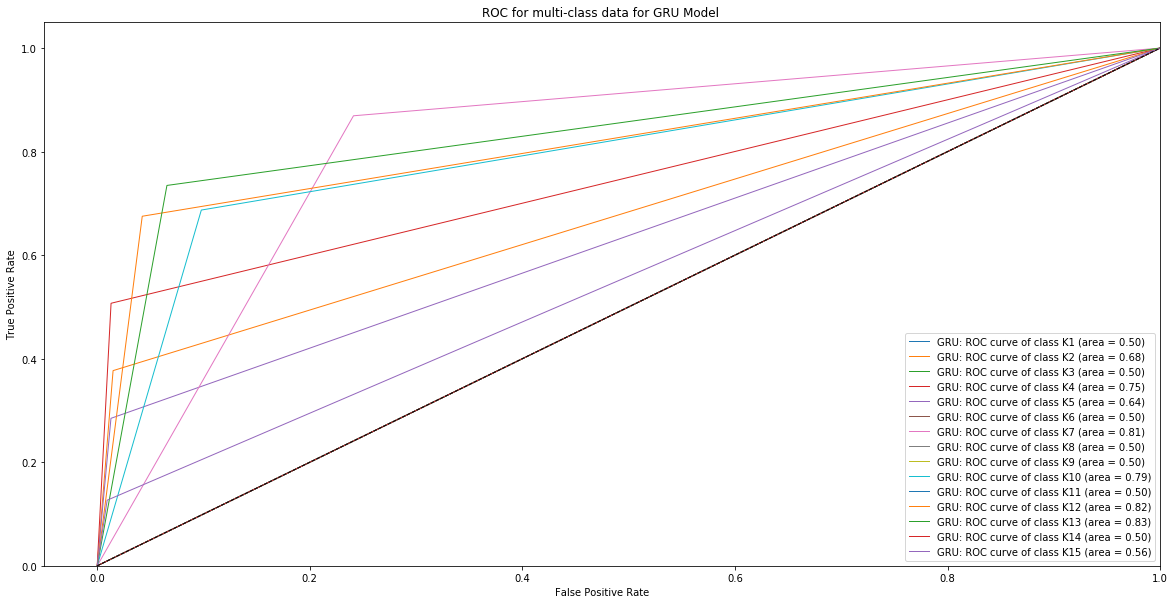

In [600]:
fig, ax = plt.subplots(figsize=(20,10))
for i in range(15):
    plt.plot(fpr_gru[i], tpr_gru[i], lw=1,
             label='GRU: ROC curve of class K{0} (area = {1:0.2f})'''.format(i+1, roc_auc_gru[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for multi-class data for GRU Model ')
plt.legend(loc="lower right")
plt.show()

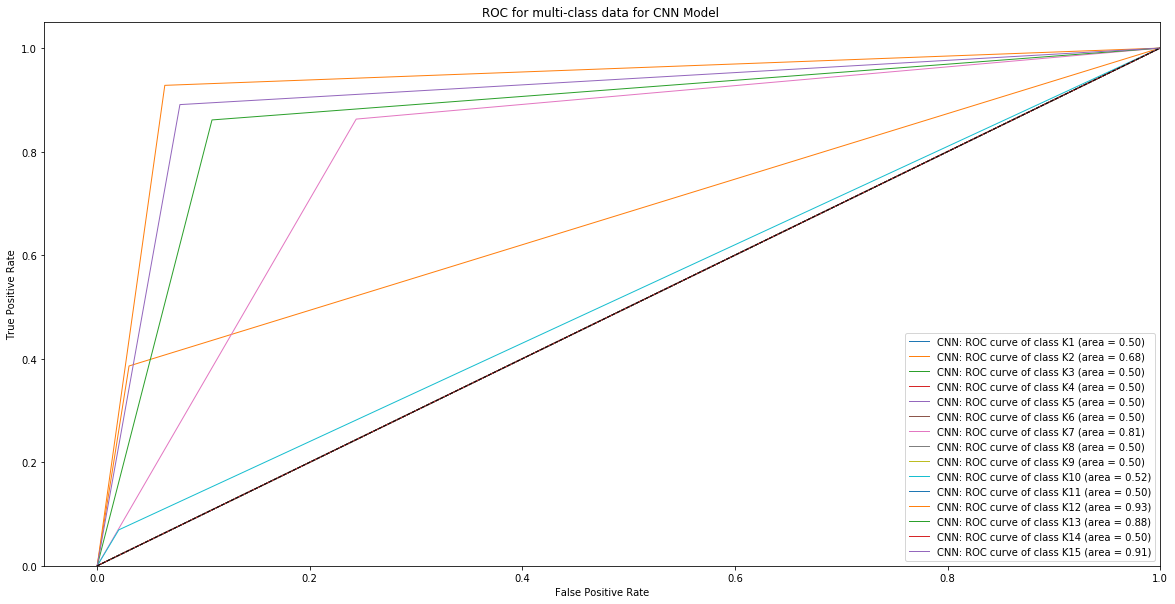

In [601]:
fig, ax = plt.subplots(figsize=(20,10))
for i in range(15):
    plt.plot(fpr_cnn[i], tpr_cnn[i], lw=1,
             label='CNN: ROC curve of class K{0} (area = {1:0.2f})'''.format(i+1, roc_auc_cnn[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for multi-class data for CNN Model ')
plt.legend(loc="lower right")
plt.show()

Both models were trained for 10 epochs, and we evaluate the performance of both models in test data set. From above ROC curves, it is apparent that the GRU model has a better performance in classifying K4, K5 and K10, while the CNN model has a better performance in K12, K13, and K15. The accuracy for CNN model is 0.56, whereas the accuracy for GRU model is 0.6. To get higher accuracy, we may need to train models with more epochs.